In [1]:
# ✅ STEP 1: Setup - Install Dependencies
!pip install -q torch torchvision torchaudio
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!pip install -q opencv-python matplotlib transformers ftfy regex faiss-cpu
!pip install -q transformers faiss-cpu
!pip install -q transformers accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 54.2 MB/s eta 0:00:00


In [2]:
# ✅ STEP 2: Import Required Libraries
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from segment_anything import sam_model_registry, SamPredictor
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel
import requests
from io import BytesIO

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [3]:
# Download SAM Checkpoint (only once)
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -O sam_vit_b.pth

In [4]:
from segment_anything import sam_model_registry, SamPredictor
# ✅ STEP 3: Load Models

# Load SAM model
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b.pth")
sam.to(device)
predictor = SamPredictor(sam)

In [5]:
#Run Captioning with BLIP
from transformers import BlipProcessor, BlipForConditionalGeneration

# Load BLIP model
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [6]:
# Load CLIP model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [7]:
# @title Vision_Agent
#Run Captioning with BLIP
from transformers import BlipProcessor, BlipForConditionalGeneration


# Generate caption
def generate_caption(image_pil):
    inputs = blip_processor(image_pil, return_tensors="pt").to(device)
    out = blip_model.generate(**inputs,do_sample=True,
        top_p=0.9,            # Nucleus sampling
        temperature=0.8,       # Add variability
        max_length=100,
        repetition_penalty=1.2)
    caption = blip_processor.decode(out[0], skip_special_tokens=True)
    return caption

#caption = generate_caption(image)
#print("📝 Caption:", caption)

In [9]:
# Take URL input from user
def User_input_image():

    # Load image from the provided URL
    # Ask for input method
    input_choice = input("📷 Enter 1 to upload from your device, or 2 to enter an image URL: ").strip()

    if input_choice == "1":
        print("📂 Please upload your image file...")
        uploaded = files.upload()
        image = Image.open(list(uploaded.values())[0]).convert("RGB")

    elif input_choice == "2":
        image_url = input("🔗 Enter the URL of your image: ").strip()
        try:
            response = requests.get(image_url)
            image = Image.open(BytesIO(response.content)).convert("RGB")
        except:
            raise ValueError("❌ Failed to load image from URL. Please check the link.")

    else:
        raise ValueError("❌ Invalid choice. Please type 1 or 2.")

    # Convert to NumPy array for downstream use
    image_np = np.array(image)

    # Show the image
    plt.imshow(image)
    plt.axis("off")
    plt.title("✅ Loaded Image")
    plt.show()


    # Convert to OpenCV format (BGR)
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    predictor.set_image(image_bgr)

    # Input point in the center of the image
    input_point = np.array([[image.width // 2, image.height // 2]])
    input_label = np.array([1])  # 1 = positive label

    # Generate segmentation masks
    masks, scores, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True
    )

    # Display masks
    plt.figure(figsize=(12, 4))
    for i, mask in enumerate(masks):
        plt.subplot(1, 3, i+1)
        plt.imshow(image_np)
        plt.imshow(mask, alpha=0.6, cmap='jet')
        plt.title(f"Mask {i+1}")
        plt.axis("off")
    plt.show()
    caption = generate_caption(image)
    print("📝 Caption:", caption)
    return caption


In [10]:
import re
def extract_keywords_from_caption(caption_):
    if not isinstance(caption, str) or not caption.strip():
        return []

    keywords = re.findall(r'\b\w+\b', caption.lower())
    stopwords = {"a", "the", "at", "on", "in", "with", "and", "of", "to", "is", "by", "an"}
    print("📝 Extracted tag from caption:", [kw for kw in keywords if kw not in stopwords])
    return [kw for kw in keywords if kw not in stopwords]



In [11]:
# @title Destination_Match_Agent
from google.colab import files
uploaded_index = files.upload()  # Select: unsplash_clip.index and unsplash_clip.index

Saving unsplash_clip.index to unsplash_clip.index


In [12]:
from google.colab import files
uploaded = files.upload()  # Select: unsplash_clip.index and unsplash_clip_metadata.csv

Saving unsplash_clip_metadata.csv to unsplash_clip_metadata.csv


In [13]:
print("📂 Uploaded file names:", list(uploaded.keys()))
print("📂 Uploaded file names:", list(uploaded_index.keys()))


📂 Uploaded file names: ['unsplash_clip_metadata.csv']
📂 Uploaded file names: ['unsplash_clip.index']


In [14]:
import faiss
import pandas as pd

# Get filenames
index_file = [f for f in uploaded_index if f.endswith(".index")][0]
csv_file = [f for f in uploaded if f.endswith(".csv")][0]

# Load files
faiss_index = faiss.read_index(index_file)
metadata_df = pd.read_csv(csv_file)

print("✅ FAISS index and metadata loaded.")
print("🧮 Metadata shape:", metadata_df.shape)


# Simply print all values in the column
#for i, val in enumerate(metadata_df["photo_location_country"]):
    #print(f"[{i+1}] {val}")


✅ FAISS index and metadata loaded.
🧮 Metadata shape: (24996, 7)


In [15]:
def get_best_location(row):
    for col in [
        "photo_location_city",
        "photo_location_country",
        "ai_primary_landmark_name"
    ]:
        val = row.get(col)
        if isinstance(val, str) and val.strip():
            return val.strip()
    return "Unknown"

metadata_df["resolved_location"] = metadata_df.apply(get_best_location, axis=1)


In [16]:
#Setup Embedding Function
def get_clip_embedding(text):
    inputs = clip_processor(text=[text], return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        return clip_model.get_text_features(**inputs).cpu().numpy().astype("float32")

#Define Matching Function with BLIP Tags
def match_from_blip_tags(blip_tags, top_k):
    query = ", ".join(blip_tags)
    query_emb = get_clip_embedding(query)

    distances, indices = faiss_index.search(query_emb, top_k)

    results = []
    for i, idx in enumerate(indices[0]):
        row = metadata_df.iloc[idx]
        results.append({
            "rank": i + 1,
            "photo_id": row.get("photo_id"),
            "image_url": row.get("photo_image_url"),
            "description": row.get("ai_description"),
            "location": row.get("resolved_location", "Unknown") if "resolved_location" in row else "Unknown",
            "distance": float(distances[0][i])
        })
    return results



📷 Enter 1 to upload from your device, or 2 to enter an image URL: 2
🔗 Enter the URL of your image: https://www.thetimes.com/imageserver/image/%2Fmethode%2Ftimes%2Fprod%2Fweb%2Fbin%2F7510fc3d-ce85-4200-a7cf-49d6f22ea9e7.jpg?crop=4999%2C2812%2C0%2C0&format=webp&resize=1500


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


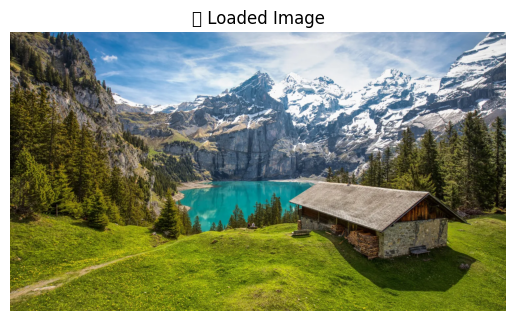

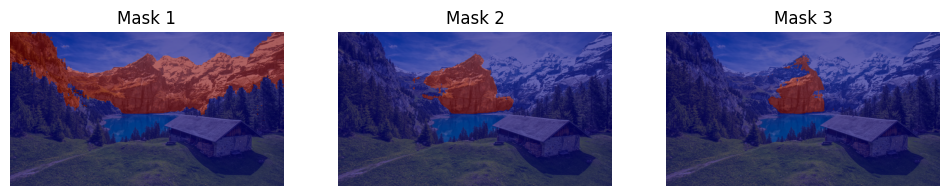

📝 Caption: the swiss alps are surrounded by majestic, spectacular lakes and stunning landscapes
📝 Extracted tag from caption: ['swiss', 'alps', 'are', 'surrounded', 'majestic', 'spectacular', 'lakes', 'stunning', 'landscapes']
[1] New Zealand
  Description: photo of mountain alps
  Image URL  : https://images.unsplash.com/photo-1473984951266-787b955c9e0b
  Distance   : 25.5415

[2] United States
  Description: photo of mountain alps
  Image URL  : https://images.unsplash.com/photo-1483422680025-d611eb867c4f
  Distance   : 25.5415

[3] Adelboden
  Description: landscape photo of mountain alps
  Image URL  : https://images.unsplash.com/photo-1458668383970-8ddd3927deed
  Distance   : 25.8790

[4] Indonesia
  Description: mountain alps
  Image URL  : https://images.unsplash.com/photo-1446435210126-bfa18ee3b7a1
  Distance   : 25.9235

[5] Unknown
  Description: mountain alps
  Image URL  : https://images.unsplash.com/photo-1431664161086-95e609b5768f
  Distance   : 25.9235

[6] Unknown
  Des

In [17]:
# Simulated BLIP tags from VisionAgent
caption = User_input_image()
#print("✅ Extracted Tags:", extract_keywords_from_caption(caption))
blip_tags = extract_keywords_from_caption(caption)
#blip_tags =['grand', 'canyon', 'overlooks', 'sunset']

# Match and display
results = match_from_blip_tags(blip_tags, top_k=25)

for r in results:
    print(f"[{r['rank']}] {r['location']}")
    print(f"  Description: {r['description']}")
    print(f"  Image URL  : {r['image_url']}")
    print(f"  Distance   : {r['distance']:.4f}\n")
